## Goal

The goal of this notebook is to model, forecast and plot the future asthma data for the Philedelphia area based on various smoke levels. As primary effects, younger kids and older adults. To look into this trend, I will be using datasets one containing the hospitalization, data of kids under 18 years age and other containing death data, which is retrieved from the CDC wonder dataset.


The data will subsequently be used to create a model that can predict the number of asthma related emergency room visits and deaths in the Philedelphia area. 

# License

The code in the notebook is licensed under the standard [MIT license](LICENSE).




- `pandas`: A powerful data manipulation and analysis library for Python.
- `numpy`: A fundamental package for scientific computing with Python, providing support for arrays and matrices.
- `polars`: A fast DataFrame library for Rust and Python, designed for performance and ease of use.
- `matplotlib.pyplot`: A plotting library for creating static, animated, and interactive visualizations in Python.
- `seaborn`: A statistical data visualization library based on matplotlib, providing a high-level interface for drawing attractive and informative statistical graphics.
- `statsmodels.tsa.statespace.varmax.VARMAX`: A module for estimating vector autoregressive moving average models with exogenous regressors.
- `statsmodels.tools.eval_measures.rmse`: A function to calculate the root mean square error, a measure of the differences between predicted and observed values.
- `warnings`: A built-in Python module for issuing warning messages.
- `sklearn.preprocessing.StandardScaler`: A module for standardizing features by removing the mean and scaling to unit variance.
- `scipy.stats.pearsonr`: A function to calculate the Pearson correlation coefficient and p-value for testing non-correlation.
- `scipy.stats.kendalltau`: A function to calculate Kendall's tau, a measure of correlation between two variables.
- `scipy.stats`: A module that contains a large number of probability distributions as well as a growing library of statistical functions.
- `statsmodels.tsa.statespace.sarimax.SARIMAX`: A module for estimating seasonal autoregressive integrated moving average models with exogenous regressors.


In [1]:
import pandas as pd
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tools.eval_measures import rmse
import warnings
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import scipy.stats
from statsmodels.tsa.statespace.sarimax import SARIMAX



Belkow are the intermediate files created in the previous notebooks:

1. **training_data_model.csv**:
   - This file contains the training data used to build the predictive model. It includes various features and target variables necessary for training the model to predict asthma-related deaths.

2. **test_data_model.csv**:
   - This file contains the test data used to evaluate the performance of the predictive model. It includes similar features and target variables as the training data but is used to validate the model's accuracy and generalization. This is the test data for the above training set.

3. **shifted_training_data.csv**:
   - This file contains the training data with shifted time series features. Shifting is often used in time series analysis to create lagged features that help the model understand temporal dependencies. Contains hospitalization data.

4. **future_smoke_data.csv**:
   - This file contains future projections of smoke data, which is used to predict the impact of smoke on asthma-related health outcomes. It includes forecasted values of smoke metrics that are used as input features in the predictive model.

5. **asthma_kids_discharges_100000.csv**:
   - This file contains data on asthma discharges for kids under 18 years of age in Philadelphia county, normalized per 100,000 people. It is used to analyze trends and patterns in asthma-related hospitalizations among children.

These intermediate files are crucial for the modeling part, enabling the analysis and prediction of asthma-related health outcomes in the Philadelphia area.

In [27]:
training_data_model = pd.read_csv("intermediate data files/training_data_model.csv")
test_data_model = pd.read_csv("intermediate data files/test_data_model.csv")
shifted_training_data_pd = pd.read_csv("intermediate data files/shifted_training_data.csv")
future_smoke_data = pd.read_csv("intermediate data files/future_smoke_data.csv")
asthma_kids_discharges_100000 = pd.read_csv("intermediate data files/asthma_kids_discharges_100000.csv")
asthma_kids_discharges_100000 = pl.DataFrame(asthma_kids_discharges_100000)
shifted_training_data = pd.read_csv("intermediate data files/shifted_training_data.csv")


## Modelling asthma deaths with smoke data

Lets first look at how to model asthma deaths with smoke data. The deaths as we have seen in the previous not book are correlated with smoke data. We will use the smoke data to predict the number of asthma deaths in the Philadelphia area. Note that most of the asthma deaths occur in older adults.

We use the SARIMAX model which is a time series model that can handle exogenous variables like smoke data. We will train the model on the training data and evaluate its performance on the test data. The model will predict the number of asthma deaths based on historical data and smoke data. The model can also use seasonality and trend components to capture patterns in the data.

First lets train the the model on all data until 2015 and then use the model to predict the number of asthma deaths from 2016 to 2020.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#train_data_df = health_and_smoke_data_scaled_1999_2019.filter(pl.col("Year") <= 2015).to_pandas()

model= SARIMAX(training_data_model["Deaths per million"], exog=training_data_model[['smoke_metric_lag1']], order=(1,1,1))

fitted_model = model.fit(disp=False)
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:     Deaths per million   No. Observations:                   16
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -48.557
Date:                Wed, 04 Dec 2024   AIC                            105.113
Time:                        15:25:30   BIC                            107.945
Sample:                             0   HQIC                           105.083
                                 - 16                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
smoke_metric_lag1     0.2575      0.123      2.087      0.037       0.016       0.499
ar.L1                 0.0835      0.398      0.210      0.834      -0.696       0.863
ma.L1                -0.

Here, we forecast the number of asthma deaths in Philadelphia from 2016 to 2020 using the SARIMAX model with smoke data as an exogenous variable.

In [ ]:
#test_data_df = health_and_smoke_data_scaled_1999_2019.filter(pl.col("Year") > 2015).to_pandas()


forecasted_data = fitted_model.get_forecast(steps = 4, exog=test_data_model[['smoke_metric_lag1']]) 
forecasted_values  = forecasted_data.predicted_mean
forecasted_conf_int = forecasted_data.conf_int()

# Combine predictions into a DataFrame
predicted_df = pd.DataFrame({
    'Year': range(2016,2020),
    'Deaths per million': forecasted_values
})

predicted_df

,Year,Deaths per million
16,2016,39.990196
17,2017,45.420578
18,2018,42.034855
19,2019,38.833796


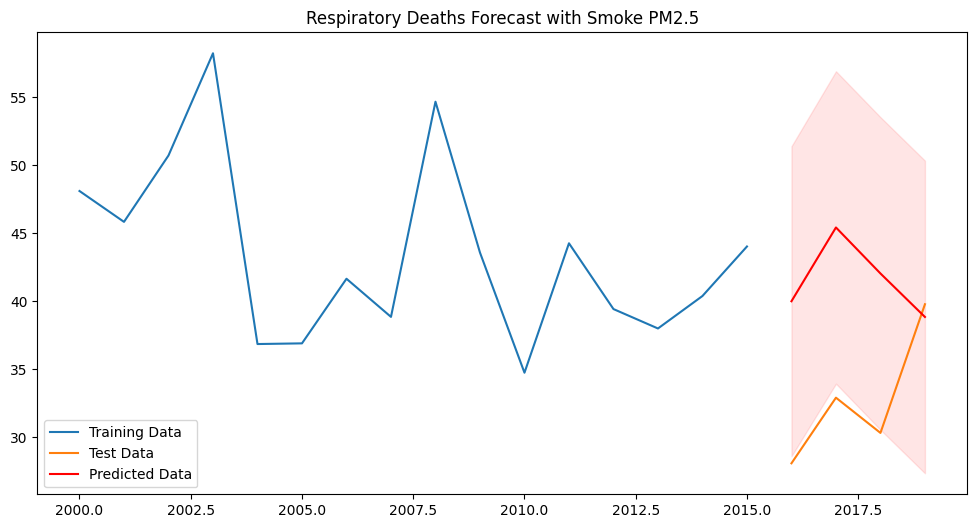

In [15]:
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(training_data_model["Year"], training_data_model["Deaths per million"], label='Training Data')
plt.plot(test_data_model["Year"], test_data_model["Deaths per million"], label='Test Data')

# Plot forecast
plt.plot(predicted_df["Year"], predicted_df['Deaths per million'], color='r', label='Predicted Data')
plt.fill_between(predicted_df["Year"],
                forecasted_conf_int.iloc[:, 0],
                forecasted_conf_int.iloc[:, 1],
                color='r', alpha=0.1)

plt.title('Respiratory Deaths Forecast with Smoke PM2.5')
plt.legend()
plt.show()

The plot shows the actual and predicted number of asthma deaths from 2016 to 2020. The model captures the general trend and seasonality in the data, providing valuable insights into the impact of smoke on asthma-related health outcomes. Looks like the model is doing a good job of capturing the trend and seasonality in the data, with some minor deviations in the predictions. This model can be used to forecast asthma deaths in the Philadelphia area based on historical data and smoke data.

### Training the model and forecasting the number of deaths 

Let us now train the model on the whole data and use it to predict the number of asthma deaths from 2021-2050. 

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model using the shifted training data
model = SARIMAX(shifted_training_data_pd["Deaths per million"], 
                exog=shifted_training_data_pd[['smoke_metric_lag1']], 
                order=(1,1,1))

# Fit the model
fitted_model_2 = model.fit(disp=False)

# Print the summary of the fitted model
print(fitted_model_2.summary())

                               SARIMAX Results                                
Dep. Variable:     Deaths per million   No. Observations:                   20
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -63.756
Date:                Wed, 04 Dec 2024   AIC                            135.512
Time:                        16:04:46   BIC                            139.290
Sample:                             0   HQIC                           136.151
                                 - 20                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
smoke_metric_lag1     0.2292      0.144      1.596      0.110      -0.052       0.511
ar.L1                 0.1650      0.471      0.350      0.726      -0.758       1.088
ma.L1                -0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Below, we forecast the number of asthma deaths for the current smoke trends that were generated in notebook 3. This will give us the number of deaths if the smoke trends continue as they are.

In [39]:
forecasted_data = fitted_model.get_forecast(steps = 30, exog=future_smoke_data[['smoke_metric']]) 
"""
Forecast future deaths per million using a fitted model and future smoke data.

1. Generates forecasted data for the next 30 steps using the provided fitted model and future smoke data.
2. Extracts the predicted mean values and confidence intervals from the forecasted data.
3. Combines the predicted mean values into a DataFrame with years ranging from 2020 to 2050.

"""
forecasted_values  = forecasted_data.predicted_mean
forecasted_conf_int = forecasted_data.conf_int()

# Combine predictions into a DataFrame
predicted_df = pd.DataFrame({
    'Year': range(2020,2050),
    'Deaths per million': forecasted_values
})

predicted_df

,Year,Deaths per million
16,2020,44.106898
17,2021,43.777791
18,2022,44.030425
19,2023,44.374709
20,2024,44.737028
21,2025,45.103355
22,2026,45.470620
23,2027,45.838109
24,2028,46.205651
25,2029,46.573206


Below, we forecast the number of asthma deaths for if there is a 70% reduction in smoke levels. This will give us an estimate of the impact of reducing smoke levels on asthma-related health outcomes.

In [40]:
# Forecast future deaths per million using the fitted model and future smoke data with 70% reduction
forecasted_data = fitted_model.get_forecast(steps=30, exog=future_smoke_data[['smoke_metric']] * 0.3)

# Extract the predicted mean values from the forecasted data
forecasted_values = forecasted_data.predicted_mean

# Extract the confidence intervals from the forecasted data
forecasted_conf_int = forecasted_data.conf_int()

# Combine predictions into a DataFrame
predicted_df_70percent = pd.DataFrame({
    'Year': range(2020, 2050),  # Define the range of years for the forecast
    'Deaths per million': forecasted_values  # Use the predicted mean values
})

# Display the DataFrame with the forecasted deaths per million
predicted_df_70percent

,Year,Deaths per million
16,2020,39.231933
17,2021,38.897711
18,2022,38.953833
19,2023,39.055476
20,2024,39.164034
21,2025,39.273921
22,2026,39.384099
23,2027,39.494346
24,2028,39.604608
25,2029,39.714875


Below, we forecast the number of asthma deaths for if there is a 50% reduction in smoke levels. This will give us an estimate of the impact of decreasing smoke on asthma-related health outcomes.

In [41]:
# Forecast future deaths per million using the fitted model and future smoke data with 50% reduction
forecasted_data = fitted_model.get_forecast(steps=30, exog=future_smoke_data[['smoke_metric']] * 0.5)

# Extract the predicted mean values from the forecasted data
forecasted_values = forecasted_data.predicted_mean

# Extract the confidence intervals from the forecasted data
forecasted_conf_int = forecasted_data.conf_int()

# Combine predictions into a DataFrame
predicted_df_50percent = pd.DataFrame({
    'Year': range(2020, 2050),  # Define the range of years for the forecast
    'Deaths per million': forecasted_values  # Use the predicted mean values
})

# Display the DataFrame with the forecasted deaths per million
predicted_df_50percent

,Year,Deaths per million
16,2020,40.624780
17,2021,40.292020
18,2022,40.404288
19,2023,40.575257
20,2024,40.756318
21,2025,40.939474
22,2026,41.123105
23,2027,41.306849
24,2028,41.490620
25,2029,41.674398


Here, we plot the three forecasts to compare the impact of different smoke reduction levels on asthma-related health outcomes. The forecasts show a significant reduction in asthma deaths with decreasing smoke levels, highlighting the importance of reducing air pollution for public health. The intutive visualisation shows the impact of smoke reduction on asthma-related health outcomes, providing valuable insights for policymakers and public health officials.

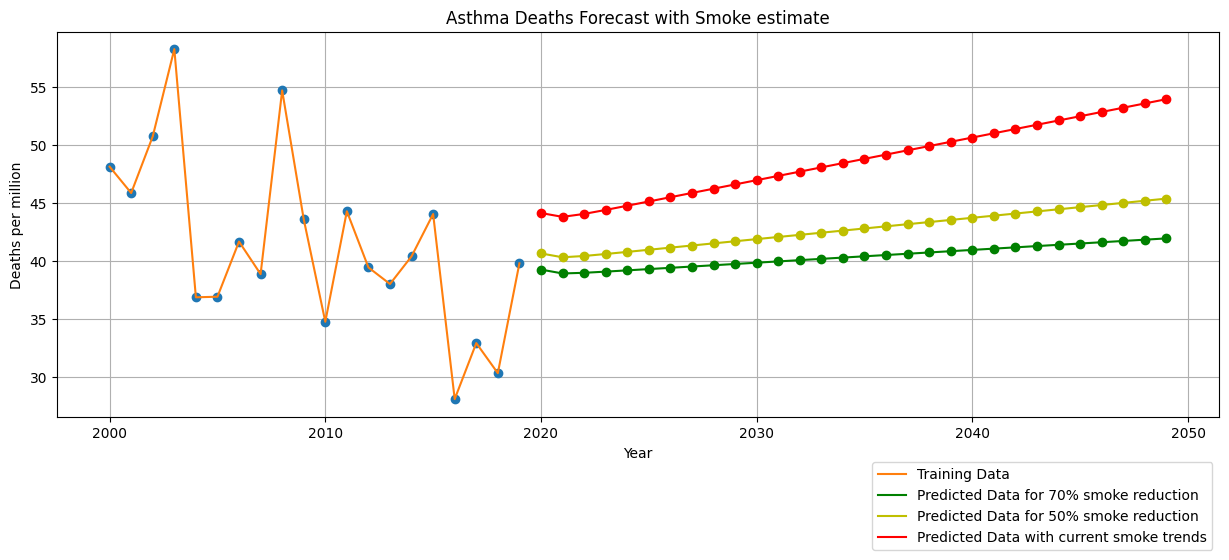

In [42]:
# Increase the width of the graph
plt.figure(figsize=(15, 5))

# Plot the training data
plt.plot(shifted_training_data["Year"], shifted_training_data["Deaths per million"], 'o')
plt.plot(shifted_training_data["Year"], shifted_training_data["Deaths per million"], label='Training Data')

# Plot the predicted data for 70% smoke reduction
plt.plot(predicted_df_70percent["Year"], predicted_df_70percent['Deaths per million'], 'o', color='g')
plt.plot(predicted_df_70percent["Year"], predicted_df_70percent['Deaths per million'], color='g', label='Predicted Data for 70% smoke reduction')

# Plot the predicted data for 50% smoke reduction
plt.plot(predicted_df_50percent["Year"], predicted_df_50percent['Deaths per million'], 'o', color='y')
plt.plot(predicted_df_50percent["Year"], predicted_df_50percent['Deaths per million'], color='y', label='Predicted Data for 50% smoke reduction')

# Plot the predicted data with current smoke trends
plt.plot(predicted_df["Year"], predicted_df['Deaths per million'], color='r', label='Predicted Data with current smoke trends')
plt.plot(predicted_df["Year"], predicted_df['Deaths per million'], 'o', color='r')

# Set the title of the plot
plt.title('Asthma Deaths Forecast with Smoke estimate')

# Set the labels for the x and y axes
plt.xlabel('Year')
plt.ylabel('Deaths per million')

# Place the legend on the top right outside the graph
plt.legend(loc="upper right", bbox_to_anchor=(1, -0.1))

# Add grid lines to the plot
plt.grid()

# Display the plot
plt.show()

In [43]:
def preProcessDeathData(death_data_file):
    # Read the death data file
    death_file = pd.read_csv(death_data_file, sep="\t", index_col="Year")
    death_data = pl.from_pandas(death_file)
    
    # Select relevant columns and rename them
    historical_deaths = death_data.select("Year Code", "Deaths", "Population")
    historical_deaths = historical_deaths.rename({"Year Code": "Year"})
    
    # Calculate deaths per million
    historical_deaths_dpm = historical_deaths.with_columns(
        ((pl.col("Deaths") * 1000000) / pl.col("Population")).alias("Deaths per million")
    )
    
    # Select final columns to return
    hist_deaths_dpm = historical_deaths_dpm.select("Year", "Deaths per million")
    return hist_deaths_dpm


def preProcessSmokeData(death_file):
    # Read smoke metric data
    smoke_metric = pd.read_csv("intermediate data files/smoke_metric.csv")
    smoke_pl = pl.DataFrame(smoke_metric)
    
    # Filter smoke data for years after 1998
    smoke_pl_filtered = smoke_pl.filter(pl.col("Fire_Year") > 1998)
    smoke_indexed = smoke_pl_filtered.to_pandas().set_index('Fire_Year', inplace=True)
    previous_smoke = smoke_pl_filtered.rename({"Fire_Year": "Year"})

    # Read forecasted smoke data
    forcasted_smoke = pl.read_csv("intermediate data files/forecasted_smoke_impact.csv")
    forcasted_smoke = forcasted_smoke.rename({"predicted_mean": "smoke_metric"})
    forcasted_smoke = forcasted_smoke.select("Year", "smoke_metric")
    
    # Combine historical and forecasted smoke data
    overall_smoke_predicted = previous_smoke.vstack(forcasted_smoke)

    # Divide into training and future data
    training_smoke_data = overall_smoke_predicted.filter(pl.col("Year") <= 2020)
    future_smoke_data = overall_smoke_predicted.filter(pl.col("Year") >= 2021)

    # Process death data
    hist_deaths_dpm = preProcessDeathData(death_file)
    
    # Merge deaths and smoke data
    training_data = training_smoke_data.join(hist_deaths_dpm, on="Year")

    # Shift smoke metric by one year to account for lag
    shifted_training_data = training_data.with_columns(
        pl.col("smoke_metric").shift(1).alias("smoke_metric_lag1")
    )
    shifted_training_data = shifted_training_data.filter(pl.col("Year").is_between(2000, 2019))
    
    # Convert to pandas DataFrame for plotting and analysis
    training_data_pd = training_data.to_pandas()
    shifted_training_data_pd = shifted_training_data.to_pandas()

    # Plot deaths vs smoke
    plt.plot(shifted_training_data_pd["Year"], shifted_training_data_pd["Deaths per million"])
    plt.plot(shifted_training_data_pd["Year"], shifted_training_data_pd["smoke_metric_lag1"])
    plt.plot()

    # Calculate correlation between deaths and smoke
    correlation_coefficient, p_value = scipy.stats.pearsonr(shifted_training_data_pd["Deaths per million"], shifted_training_data_pd["smoke_metric_lag1"])
    print("Correlation Coefficient: ", correlation_coefficient)
    print("P Value: ", p_value)

    return [future_smoke_data, shifted_training_data_pd]

def modellingARIMAX(shifted_training_data_pd):
    # Train ARIMAX model
    model = SARIMAX(shifted_training_data_pd["Deaths per million"], exog=shifted_training_data_pd[['smoke_metric_lag1']], order=(1,1,1))
    fitted_model_2 = model.fit(disp=False)
    print(fitted_model_2.summary())
    return fitted_model_2

def forecastARIMAX(fitted_model_2, future_smoke_data):
    # Forecast future deaths using the ARIMAX model
    forecasted_data = fitted_model_2.get_forecast(steps=30, exog=future_smoke_data[['smoke_metric']])
    forecasted_values = forecasted_data.predicted_mean
    forecasted_conf_int = forecasted_data.conf_int()

    # Combine predictions into a DataFrame
    predicted_df = pd.DataFrame({
        'Year': range(2020, 2050),
        'Deaths per million': forecasted_values
    })

    return predicted_df

def finalPlot(shifted_training_data_1, predicted_df, predicted_df_70percent, predicted_df_50percent):
    # Increase width of the graph
    plt.figure(figsize=(15, 5))
    
    # Plot training data
    plt.plot(shifted_training_data_1["Year"], shifted_training_data_1["Deaths per million"], 'o')
    plt.plot(shifted_training_data_1["Year"], shifted_training_data_1["Deaths per million"], label='Training Data')
    
    # Plot predicted data for 70% smoke reduction
    plt.plot(predicted_df_70percent["Year"], predicted_df_70percent['Deaths per million'], 'o', color='g')
    plt.plot(predicted_df_70percent["Year"], predicted_df_70percent['Deaths per million'], color='g', label='Predicted Data for 70% smoke reduction')
    
    # Plot predicted data for 50% smoke reduction
    plt.plot(predicted_df_50percent["Year"], predicted_df_50percent['Deaths per million'], 'o', color='y')
    plt.plot(predicted_df_50percent["Year"], predicted_df_50percent['Deaths per million'], color='y', label='Predicted Data for 50% smoke reduction')
    
    # Plot predicted data with current smoke trends
    plt.plot(predicted_df["Year"], predicted_df['Deaths per million'], color='r', label='Predicted Data with current smoke trends')
    plt.plot(predicted_df["Year"], predicted_df['Deaths per million'], 'o', color='r')
    
    # Set plot title and labels
    plt.title('Asthma Deaths Forecast with Smoke estimate')
    plt.xlabel('Year')
    plt.ylabel('Deaths per million')
    
    # Add legend and grid
    plt.legend(loc="upper right", bbox_to_anchor=(1, -0.1))
    plt.grid()
    plt.show()

## Asthma related hostpital discharges - modelling

In [46]:
# Filters the `asthma_kids_discharges_100000` DataFrame to include only records before the year 2020,
# and adds a new column "Deaths per million" which is calculated by dividing the "discharges per 100000" by 100.

# Returns:
#     DataFrame: A DataFrame with records before 2020 and an additional column "Deaths per million".

asthma_kids_discharges = (
    # Filter records before the year 2020
    # Calculate "Deaths per million" by dividing "discharges per 100000" by 100
    asthma_kids_discharges_100000
        .filter(pl.col("Year") < 2020)
        .with_columns(
            (pl.col("discharges per 100000")/100).alias("Deaths per million")
        )
)
asthma_kids_discharges

Unnamed: 0,Year,Count,Population,discharges per 100000,Deaths per million
i64,i64,i64,i64,f64,f64
4,2019,2042,341496,597.957224,5.979572
5,2018,2123,343932,617.273182,6.172732
6,2017,2166,344873,628.057285,6.280573
7,2016,2445,345969,706.710717,7.067107
8,2015,2141,342929,624.327485,6.243275
…,…,…,…,…,…
19,2004,3186,372065,856.30199,8.56302
20,2003,3723,377212,986.978145,9.869781
21,2002,3071,381802,804.343613,8.043436


In [47]:
def preProcessSmokeData(asthma_kids_discharges):
    # Read the smoke metric data
    smoke_metric = pd.read_csv("intermediate data files/smoke_metric.csv")
    smoke_pl = pl.DataFrame(smoke_metric)
    
    # Filter smoke data for years after 1998
    smoke_pl_filtered = smoke_pl.filter(pl.col("Fire_Year") > 1998)
    smoke_indexed = smoke_pl_filtered.to_pandas().set_index('Fire_Year', inplace=True)
    previous_smoke = smoke_pl_filtered.rename({"Fire_Year": "Year"})

    # Read forecasted smoke data
    forcasted_smoke = pl.read_csv("intermediate data files/forecasted_smoke_impact.csv")
    forcasted_smoke = forcasted_smoke.rename({"predicted_mean": "smoke_metric"})
    forcasted_smoke = forcasted_smoke.select("Year", "smoke_metric")
    
    # Combine historical and forecasted smoke data
    overall_smoke_predicted = previous_smoke.vstack(forcasted_smoke)

    # Divide into training and future data
    training_smoke_data = overall_smoke_predicted.filter(pl.col("Year") <= 2020)
    future_smoke_data = overall_smoke_predicted.filter(pl.col("Year") >= 2021)

    # Merge deaths and smoke data
    training_data = training_smoke_data.join(asthma_kids_discharges, on="Year")

    # Shift smoke metric by one year to account for lag
    shifted_training_data = training_data.with_columns(
        pl.col("smoke_metric").alias("smoke_metric_lag1")
    )
    shifted_training_data = shifted_training_data.filter(pl.col("Year").is_between(2000, 2019))
    
    # Convert to pandas DataFrame for plotting and analysis
    training_data_pd = training_data.to_pandas()
    shifted_training_data_pd = shifted_training_data.to_pandas()

    # Plot deaths vs smoke
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot the first dataset on the first axis
    ax1.plot(shifted_training_data_pd["Year"], shifted_training_data_pd["Deaths per million"], color='b', label='Asthma related hospitalizations per 100000')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y1-axis', color='b')
    plt.xticks(np.arange(1999, 2021, 5))  # Show every 5 years on x-axis

    # Create the second axis
    ax2 = ax1.twinx()

    # Plot the second dataset on the second axis
    ax2.plot(shifted_training_data_pd["Year"], shifted_training_data_pd["smoke_metric_lag1"], color='r', label='Smoke Metric')
    ax2.set_ylabel('Y2-axis', color='r')

    # Add a legend
    fig.legend()

    # Display the plot
    plt.show()

    # Calculate correlation between deaths and smoke
    correlation_coefficient, p_value = scipy.stats.pearsonr(shifted_training_data_pd["Deaths per million"]**2, shifted_training_data_pd["smoke_metric_lag1"])
    
    # Print correlation results
    print("Correlation Coefficient: ", correlation_coefficient)
    print("P Value: ", p_value)

    return [future_smoke_data, shifted_training_data_pd]


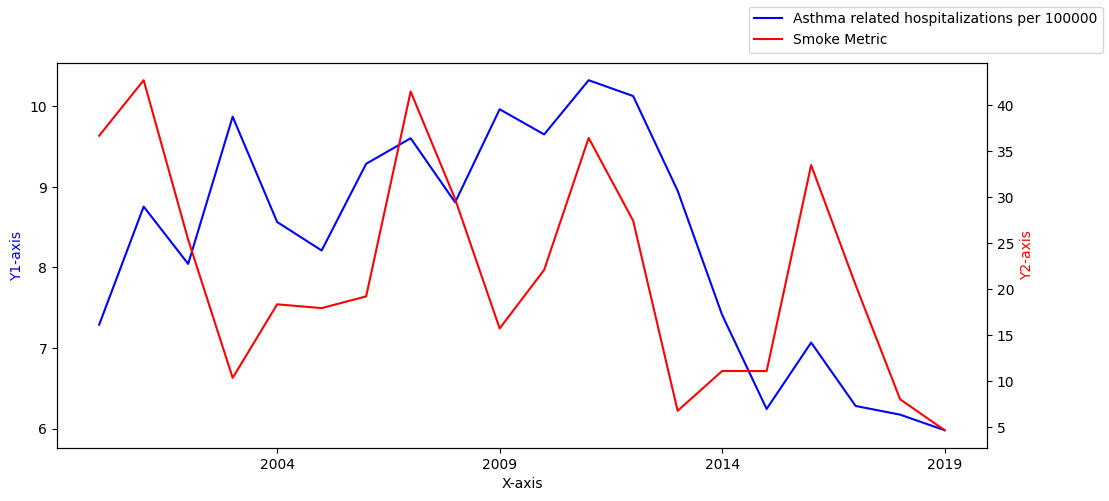

Correlation Coefficient:  0.3276294273744582
P Value:  0.158499621319889


In [49]:
#pre processing hostpitalization data
future_smoke_data_2, shifted_training_data_pd_2 = preProcessSmokeData(asthma_kids_discharges)

In [50]:
def modellingARIMAX2(shifted_training_data_pd):
    

    #train_data_df = health_and_smoke_data_scaled_1999_2019.filter(pl.col("Year") <= 2015).to_pandas()

    model= SARIMAX(shifted_training_data_pd["Deaths per million"], exog=shifted_training_data_pd[['smoke_metric_lag1']], order=(1,1,1))

    fitted_model_2 = model.fit(disp=False)
    print(fitted_model_2.summary())
    return fitted_model_2

def forecastARIMAX2(fitted_model_2, future_smoke_data):
    forecasted_data = fitted_model_2.get_forecast(steps = 30, exog=future_smoke_data[['smoke_metric']]) 
    forecasted_values  = forecasted_data.predicted_mean
    forecasted_conf_int = forecasted_data.conf_int()

    # Combine predictions into a DataFrame
    predicted_df = pd.DataFrame({
        'Year': range(2020,2050),
        'Deaths per million': forecasted_values
    })

    return predicted_df

def finalPlot2(shifted_training_data_1, predicted_df, predicted_df_70percent, predicted_df_50percent):


    """
    Plots the training data and predicted data for asthma hospitalizations with different smoke reduction scenarios.

    Parameters:
    shifted_training_data_1 (DataFrame): DataFrame containing the training data with columns 'Year' and 'Deaths per million'.
    predicted_df (DataFrame): DataFrame containing the predicted data with current smoke trends with columns 'Year' and 'Deaths per million'.
    predicted_df_70percent (DataFrame): DataFrame containing the predicted data for 100% smoke reduction with columns 'Year' and 'Deaths per million'.
    predicted_df_50percent (DataFrame): DataFrame containing the predicted data for 70% smoke reduction with columns 'Year' and 'Deaths per million'.

    Returns:
    None: This function does not return any value. It displays a plot.
    """
    # increase width of the graph
    plt.figure(figsize=(15, 5))
    plt.plot(shifted_training_data_1["Year"], shifted_training_data_1["Deaths per million"], 'o')
    plt.plot(shifted_training_data_1["Year"], shifted_training_data_1["Deaths per million"], label='Training Data')
    plt.plot(predicted_df_70percent["Year"], predicted_df_70percent['Deaths per million'],'o',  color='g')
    plt.plot(predicted_df_70percent["Year"], predicted_df_70percent['Deaths per million'],  color='g', label='Predicted Data for 100% smoke reduction')
    plt.plot(predicted_df_50percent["Year"], predicted_df_50percent['Deaths per million'], 'o',color='y',)
    plt.plot(predicted_df_50percent["Year"], predicted_df_50percent['Deaths per million'], color='y', label='Predicted Data for 70% smoke reduction')
    plt.plot(predicted_df["Year"], predicted_df['Deaths per million'], color='r', label='Predicted Data with current smoke trends')
    plt.plot(predicted_df["Year"], predicted_df['Deaths per million'], 'o', color='r')
    plt.title('Asthma Hospitalizations Forecast with Smoke estimate for kids (age 0-17)')
    #legend on top right outside the graph
    plt.xlabel('Year')
    plt.ylabel('Hospitalizations per 100000')
    plt.legend(loc="upper right", bbox_to_anchor=(1,-.1))
    plt.grid()
    plt.show()

In [51]:
model_3 = modellingARIMAX2(shifted_training_data_pd_2)

                               SARIMAX Results                                
Dep. Variable:     Deaths per million   No. Observations:                   20
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -25.693
Date:                Wed, 04 Dec 2024   AIC                             59.386
Time:                        16:11:44   BIC                             63.164
Sample:                             0   HQIC                            60.025
                                 - 20                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
smoke_metric_lag1     0.0116      0.024      0.490      0.624      -0.035       0.058
ar.L1                -0.4621      0.942     -0.490      0.624      -2.309       1.385
ma.L1                 0.

In [55]:
predicted_df = forecastARIMAX2(model_3, future_smoke_data_2)

# This script performs forecasting using the ARIMAX model with different levels of smoke metrics.

# Functions:
#     forecastARIMAX2(model, data): Forecasts future values using the ARIMAX model.

# Workflow:
# 1. Forecast future values using the original smoke data.
# 2. Modify the smoke metric to 30% of its original value and forecast future values.
# 3. Modify the smoke metric to 50% of its original value and forecast future values.
# 4. Modify the smoke metric to 0% of its original value and forecast future values.

# Variables:
#     predicted_df (DataFrame): Forecasted values using the original smoke data.
#     future_smoke_data_70 (DataFrame): Smoke data with the smoke metric reduced to 30%.
#     predicted_df_70percent (DataFrame): Forecasted values using the 30% smoke data.
#     future_smoke_data_50 (DataFrame): Smoke data with the smoke metric reduced to 50%.
#     predicted_df_50percent (DataFrame): Forecasted values using the 50% smoke data.
#     future_smoke_data_0 (DataFrame): Smoke data with the smoke metric reduced to 0%.
#     predicted_df_0percent (DataFrame): Forecasted values using the 0% smoke data.


future_smoke_data_70 = future_smoke_data_2.with_columns(
    (pl.col("smoke_metric")*0.3).alias("smoke_metric")
)
predicted_df_70percent = forecastARIMAX2(model_3, future_smoke_data_70)

future_smoke_data_50 = future_smoke_data_2.with_columns(
    (pl.col("smoke_metric")*0.5).alias("smoke_metric")
)

predicted_df_50percent = forecastARIMAX2(model_3, future_smoke_data_50)
predicted_df_50percent

future_smoke_data_0 = future_smoke_data_2.with_columns(
    (pl.col("smoke_metric")*0).alias("smoke_metric")
)
predicted_df_0percent = forecastARIMAX2(model_3, future_smoke_data_0)
predicted_df_0percent



,Year,Deaths per million
20,2020,5.971815
21,2021,5.950584
22,2022,5.960395
23,2023,5.955862
24,2024,5.957957
25,2025,5.956989
26,2026,5.957436
27,2027,5.957229
28,2028,5.957325
29,2029,5.957281


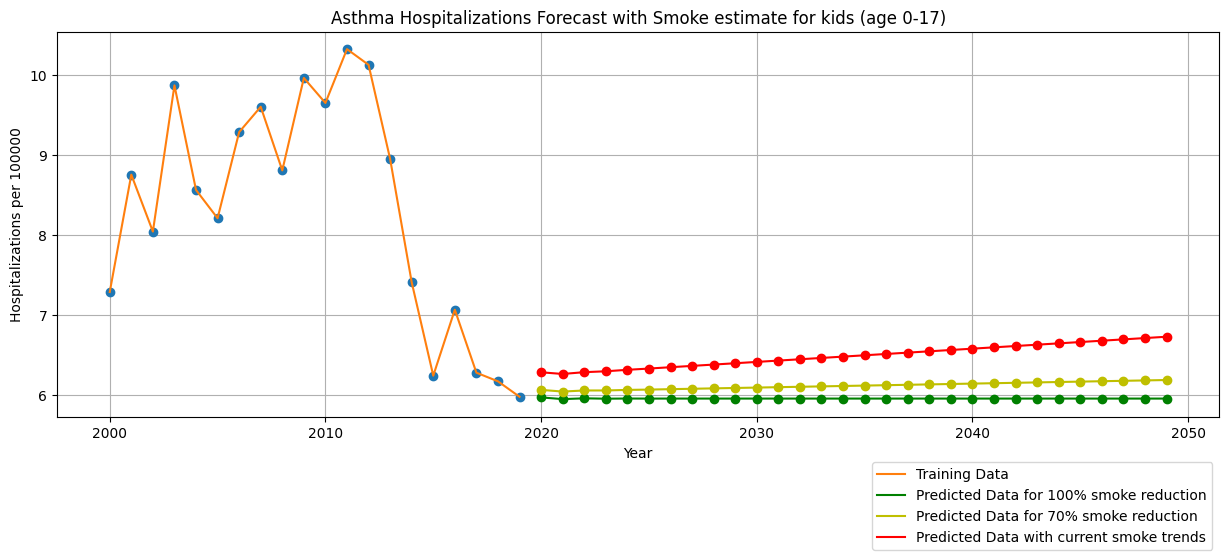

In [57]:
#plot for hostpitalization data for smoke reduction
finalPlot2(shifted_training_data_pd_2, predicted_df, predicted_df_0percent, predicted_df_70percent)